In [52]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors, __version__ as mplver
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from astropy.table import Table
from astropy import __version__ as apver
from astropy import units as u, constants as c
from scipy import stats, __version__ as spver
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Ellipse
from sklearn import __version__ as sklver
import warnings
from TESStools import *
from tqdm.notebook import tqdm
from matplotlib import lines as mlines
from matplotlib.colors import Normalize
from scipy.stats import sigmaclip
import h5py as h5

In [53]:
print(np.__version__,pd.__version__,mplver,apver,spver,sklver)

1.20.3 1.3.0 3.3.4 4.2.1 1.6.2 0.24.2


In [54]:
#We're going to need our stars...
cool_sgs = pd.read_csv('sample.csv',index_col=0)
#merged with SLFV and prewhitening info...
slfv_params = pd.read_csv('slfv_params.csv',index_col=0)
inspected = pd.read_csv('prewhitening.csv',index_col=0)
merged = pd.merge(cool_sgs,slfv_params,left_index=True,right_index=True)
merged = pd.merge(merged,inspected,left_index=True,right_index=True)

# Now we're going to look for pulsators. First, grab stars where we can extract a frequency with >5 sigma

# Grab stars where we can extract a frequency with >5 sigma
pulse_detected = merged[(merged['n_peaks'] > 0) & (merged['highest_amp']/merged['highest_amp_error'] > 5)]
print(f"{len(pulse_detected)} stars with 5-sigma frequencies out of {len(merged)} total")

# We also used a GP to see if these frequencies were significant above the SLFV
gp_pulse = pd.read_csv('Find_FYPS_GP_results.csv', index_col=0)
pulse_detected_gp = pd.merge(pulse_detected, gp_pulse, left_index=True, right_index=True)
print(f"GP reveals {len(pulse_detected_gp[pulse_detected_gp['pulse_GP']==True])} true periodic stars")

# Load in info on which stars are consistent with RR Lyrae and Beta Cepheids...
likely_rrcep = pd.read_csv('likelyRRCep.csv',index_col=0)
likely_bcep = pd.read_csv('likelyBCep.csv',index_col=0)
contaminants = pd.merge(likely_rrcep,likely_bcep,left_index=True,right_index=True)

new = pd.merge(pulse_detected_gp,contaminants,left_index=True,right_index=True)
pulse_clean = new[(new['pulse_GP'])&(~new['LikelyRR'])&(~new['LikelyCep'])&(~new['LikelyBCep'])]
print(f"Filtering out contaminants leaves us with {len(pulse_clean)} stars")

155 stars with 5-sigma frequencies out of 201 total
GP reveals 154 true periodic stars
Filtering out contaminants leaves us with 111 stars


In [55]:
#A way to grab FYPS
def fyps_box(df):
    """
    Returns part of dataframe where teff and lum are in the FYPS box
    """
    
    #tmin = df['teff'] >= 3.6
    #tmax = df['teff'] <= 4.1
    #lmax = df['lum'] <= 7.76 - 0.6*df['teff']
    lmin = df['lum'] >= 5.0 #6.23 - 0.3*df['teff']
    
    return lmin # & lmax & tmin & tmax

In [56]:
candidate_fyps = pulse_clean[fyps_box(pulse_clean)]
all_in_box = merged[fyps_box(merged)]
len(candidate_fyps), len(all_in_box), len(candidate_fyps)/len(all_in_box)

(39, 63, 0.6190476190476191)

In [57]:
nf = []
highf = []
lowf = []
teff = []
for tic, cf in candidate_fyps.iterrows():
    teff.append(cf['teff'])
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()][:,0]
        nf.append(len(good_fs))
        highf.append(good_fs.max())
        lowf.append(good_fs.min())

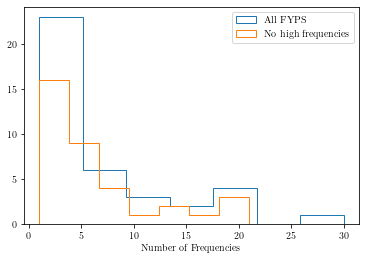

In [8]:
plt.hist(nf, histtype='step',bins='auto',label='All FYPS')
plt.hist(np.array(nf)[np.array(highf)<30], histtype='step',bins='auto',label='No high frequencies')
plt.xlabel('Number of Frequencies')
plt.legend()

In [78]:
len(np.array(nf)[(np.array(highf)<=10)&(np.array(nf)<=10)]),len(nf)

(30, 39)

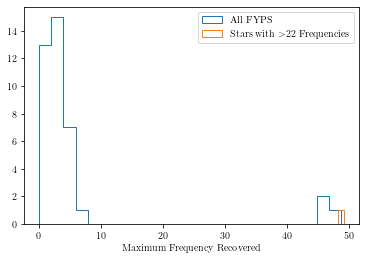

In [9]:
plt.hist(highf, histtype='step', bins='auto',label='All FYPS')
plt.hist(np.array(highf)[np.array(nf)>22], histtype='step', bins='auto', label='Stars with $>$22 Frequencies')
plt.xlabel('Maximum Frequency Recovered')
plt.legend()

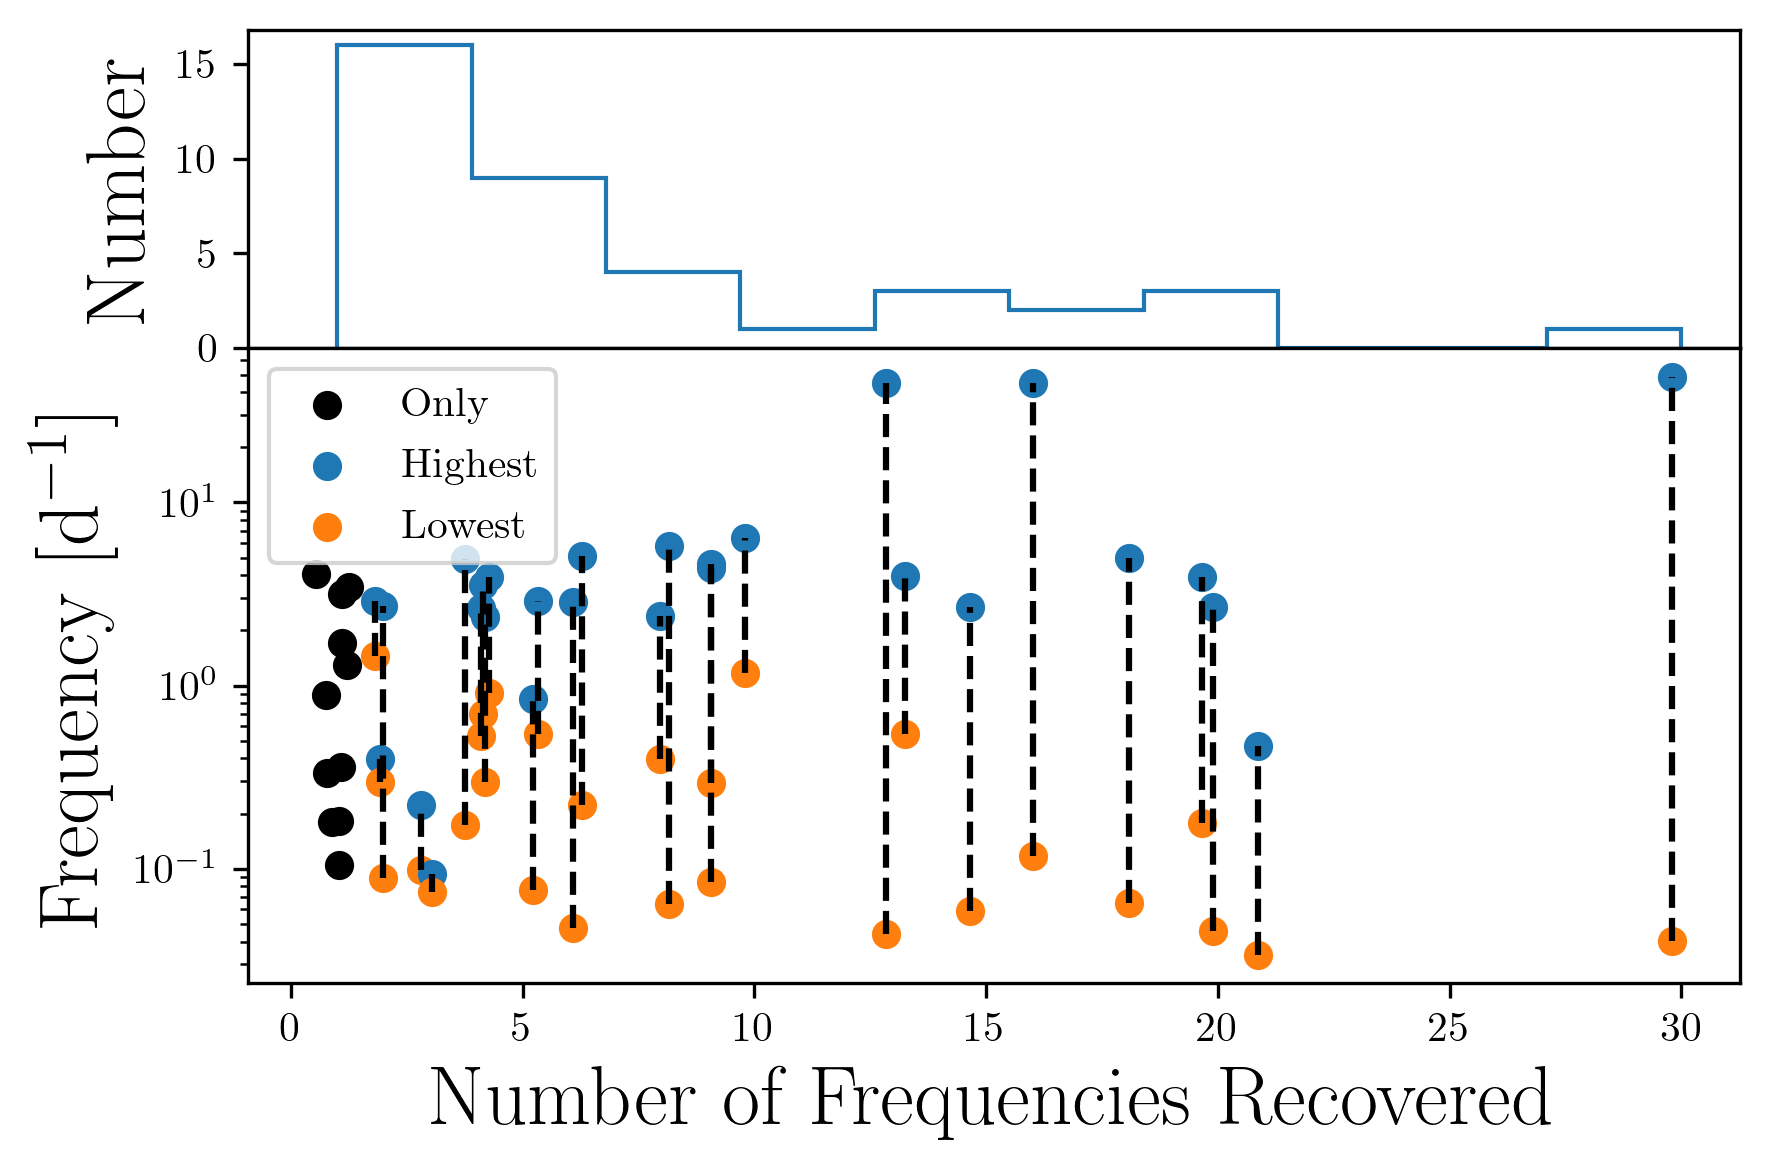

In [71]:
mosaic = """
AAA
BBB
BBB
"""
fig, ax = plt.subplot_mosaic(mosaic,dpi=300)

black_leg = False
blue_leg = False
orange_leg = False
for i in range(len(nf)):
    offset= 0.2*np.random.randn() 
    label = None
    if nf[i] == 1:
        col = 'k'
        if not black_leg:
            label = 'Only'
            black_leg = True
    else:
        col='C0'
        if not blue_leg:
            label = 'Highest'
            blue_leg = True
    ax['B'].scatter(nf[i]+offset,highf[i],c=col,label=label)
    if nf[i] != 1:
        label = None
        if not orange_leg:
            label = 'Lowest'
            orange_leg = True
        ax['B'].scatter(nf[i]+offset,lowf[i],c='C1',label=label)
        ax['B'].plot([nf[i]+offset,nf[i]+offset],[lowf[i],highf[i]],ls='--',c='k')
    
ax['B'].set_xlabel('Number of Frequencies Recovered',fontsize=20)
ax['B'].set_ylabel('Frequency [d$^{-1}$]',fontsize=20)
ax['B'].set_yscale('log')
xl = ax['B'].get_xlim()
ax['B'].legend(loc='upper left')

ax['A'].hist(nf,histtype='step')
ax['A'].set_xlim(xl)
ax['A'].set_xticks([])
ax['A'].set_yticks([0,5,10,15])
ax['A'].set_ylabel('Number',fontsize=20)


fig.tight_layout()
fig.subplots_adjust(hspace=0)
plt.savefig('../plots/FYPS_freq_props.pdf',bbox_inches='tight')

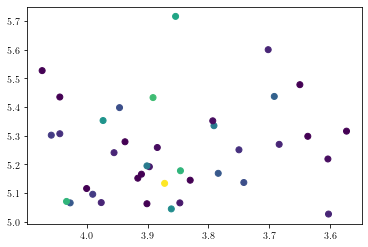

In [74]:
plt.scatter(candidate_fyps['teff'],candidate_fyps['lum'],c=nf)
plt.gca().invert_xaxis()

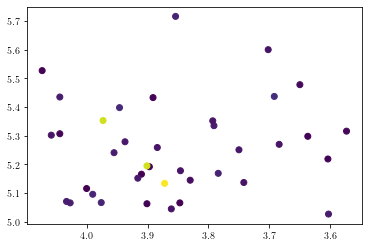

In [75]:
plt.scatter(candidate_fyps['teff'],candidate_fyps['lum'],c=highf)
plt.gca().invert_xaxis()

# Let's make a plot showing the evolution of FYPS frequencies along the HR diagram

# Azalee suggested making a density plot, which is a great idea! First we need to transform into a space where the KDE kernel is not stretched along one axis or another

# Let's look at the behavior of both the highest amplitude frequency and the density in frequencies as a function of effective temperature, all in the same figure!

In [46]:
def compute_KDE(xdata, ydata, scale=True, bandwidth=0.5, 
                KDE_res=1000, teff_bandwidth=None, fteff_bandwidth=None):
    assert (teff_bandwidth is None) == (fteff_bandwidth is None)
    data_kde = np.array([xdata,ydata]).T
    if scale:
        scaler = StandardScaler()
        data_kde = scaler.fit_transform(data_kde)
    data_teff = data_kde[:,0][:,np.newaxis]
    if teff_bandwidth is not None:
        bandwidth = teff_bandwidth
    kde_teff = KernelDensity(bandwidth = bandwidth)
    kde_teff.fit(data_teff)
    xteff = np.linspace(data_teff.min(),data_teff.max(),KDE_res)

    #compute the KDE
    KDE_score_teff = np.exp(kde_teff.score_samples(xteff.reshape(-1, 1)))
    
    if fteff_bandwidth is not None:
        bandwidth = fteff_bandwidth
    kde_fteff = KernelDensity(bandwidth=bandwidth)
    kde_fteff.fit(data_kde)

    X, Y = np.meshgrid(np.linspace(np.min(data_kde[:,0]),np.max(data_kde[:,0]),KDE_res), 
                   np.linspace(np.min(data_kde[:,1]),np.max(data_kde[:,1]),KDE_res))

    xy = np.vstack([X.ravel(), Y.ravel()]).T

    #compute the KDE on a 100x100 grid of points
    KDE_score_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

    KDE_teff_proj = np.tile(KDE_score_teff, (KDE_res,1))

    KDE_fteff_scale = KDE_score_fteff/KDE_teff_proj
    
    if scale:
        mesh_inv = scaler.inverse_transform(xy).reshape(KDE_res,KDE_res,2)
        X = mesh_inv[:,:,0]
        Y = mesh_inv[:,:,1]
        
        widths = [[0.0,0.0],[0.0,bandwidth],[bandwidth,0.0]]
        width_inv = scaler.inverse_transform(widths)
        y_width = np.abs(width_inv[0,1]-width_inv[1,1])
        x_width = np.abs(width_inv[0,0]-width_inv[2,0])
        return KDE_fteff_scale, X, Y, x_width, y_width
        
    return KDE_fteff_scale, X, Y

In [83]:
filter_high_frequencies = True
filter_many_frequencies = True
KDE_res = 1000 #resolution of KDE

x_data_kde = []
y_data_kde = []
z_data_kde = []
x_data_scatter = []
y_data_scatter = []
z_data_scatter = []
amp_data_scatter = []
tic_data_scatter = []
gal_data_scatter = []
nf_data_scatter = []
highf_data_scatter = []
lowf_data_scatter = []
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    x_data_scatter.append(cf['teff'])
    y_data_scatter.append(good_fs[0,0])
    amp_data_scatter.append(cf['highest_amp'])
    tic_data_scatter.append(tic)
    gal_data_scatter.append(cf['Gal'])
    nf_data_scatter.append(len(good_fs))
    highf_data_scatter.append(good_fs[:,0].max())
    lowf_data_scatter.append(good_fs[:,0].min())
    
    lum_erg = (np.power(10.0,cf['lum'])*u.Lsun).to(u.erg/u.s)
    t_kelv = np.power(10.0,cf['teff'])*u.Kelvin
    sigma_T4 = c.sigma_sb * np.power(t_kelv, 4.0)
    r_2 = lum_erg / (4.0*np.pi*sigma_T4)
    rcm = np.sqrt(r_2).to(u.cm)
    M = 15.0*u.Msun
    rho = (3*M / (4*np.pi*np.power(rcm,3.0))).to(u.gram / (u.cm)**3.0)
    tdyn = (1.0 / np.sqrt(c.G * rho)).to(u.day)
    
    z_data_scatter.append(good_fs[0,0]*tdyn/u.d)
    
    for f in good_fs[:,0]:
        x_data_kde.append(cf['teff'])
        y_data_kde.append(f)
        z_data_kde.append(f*tdyn/u.d)
    
KDE_teff_f, Xteff, Yf, xtf_width, ytf_width = compute_KDE(x_data_kde, y_data_kde)
KDE_teff_sigma, Xteff_sig, Ysigma, xts_width, yts_width = compute_KDE(x_data_kde, z_data_kde)

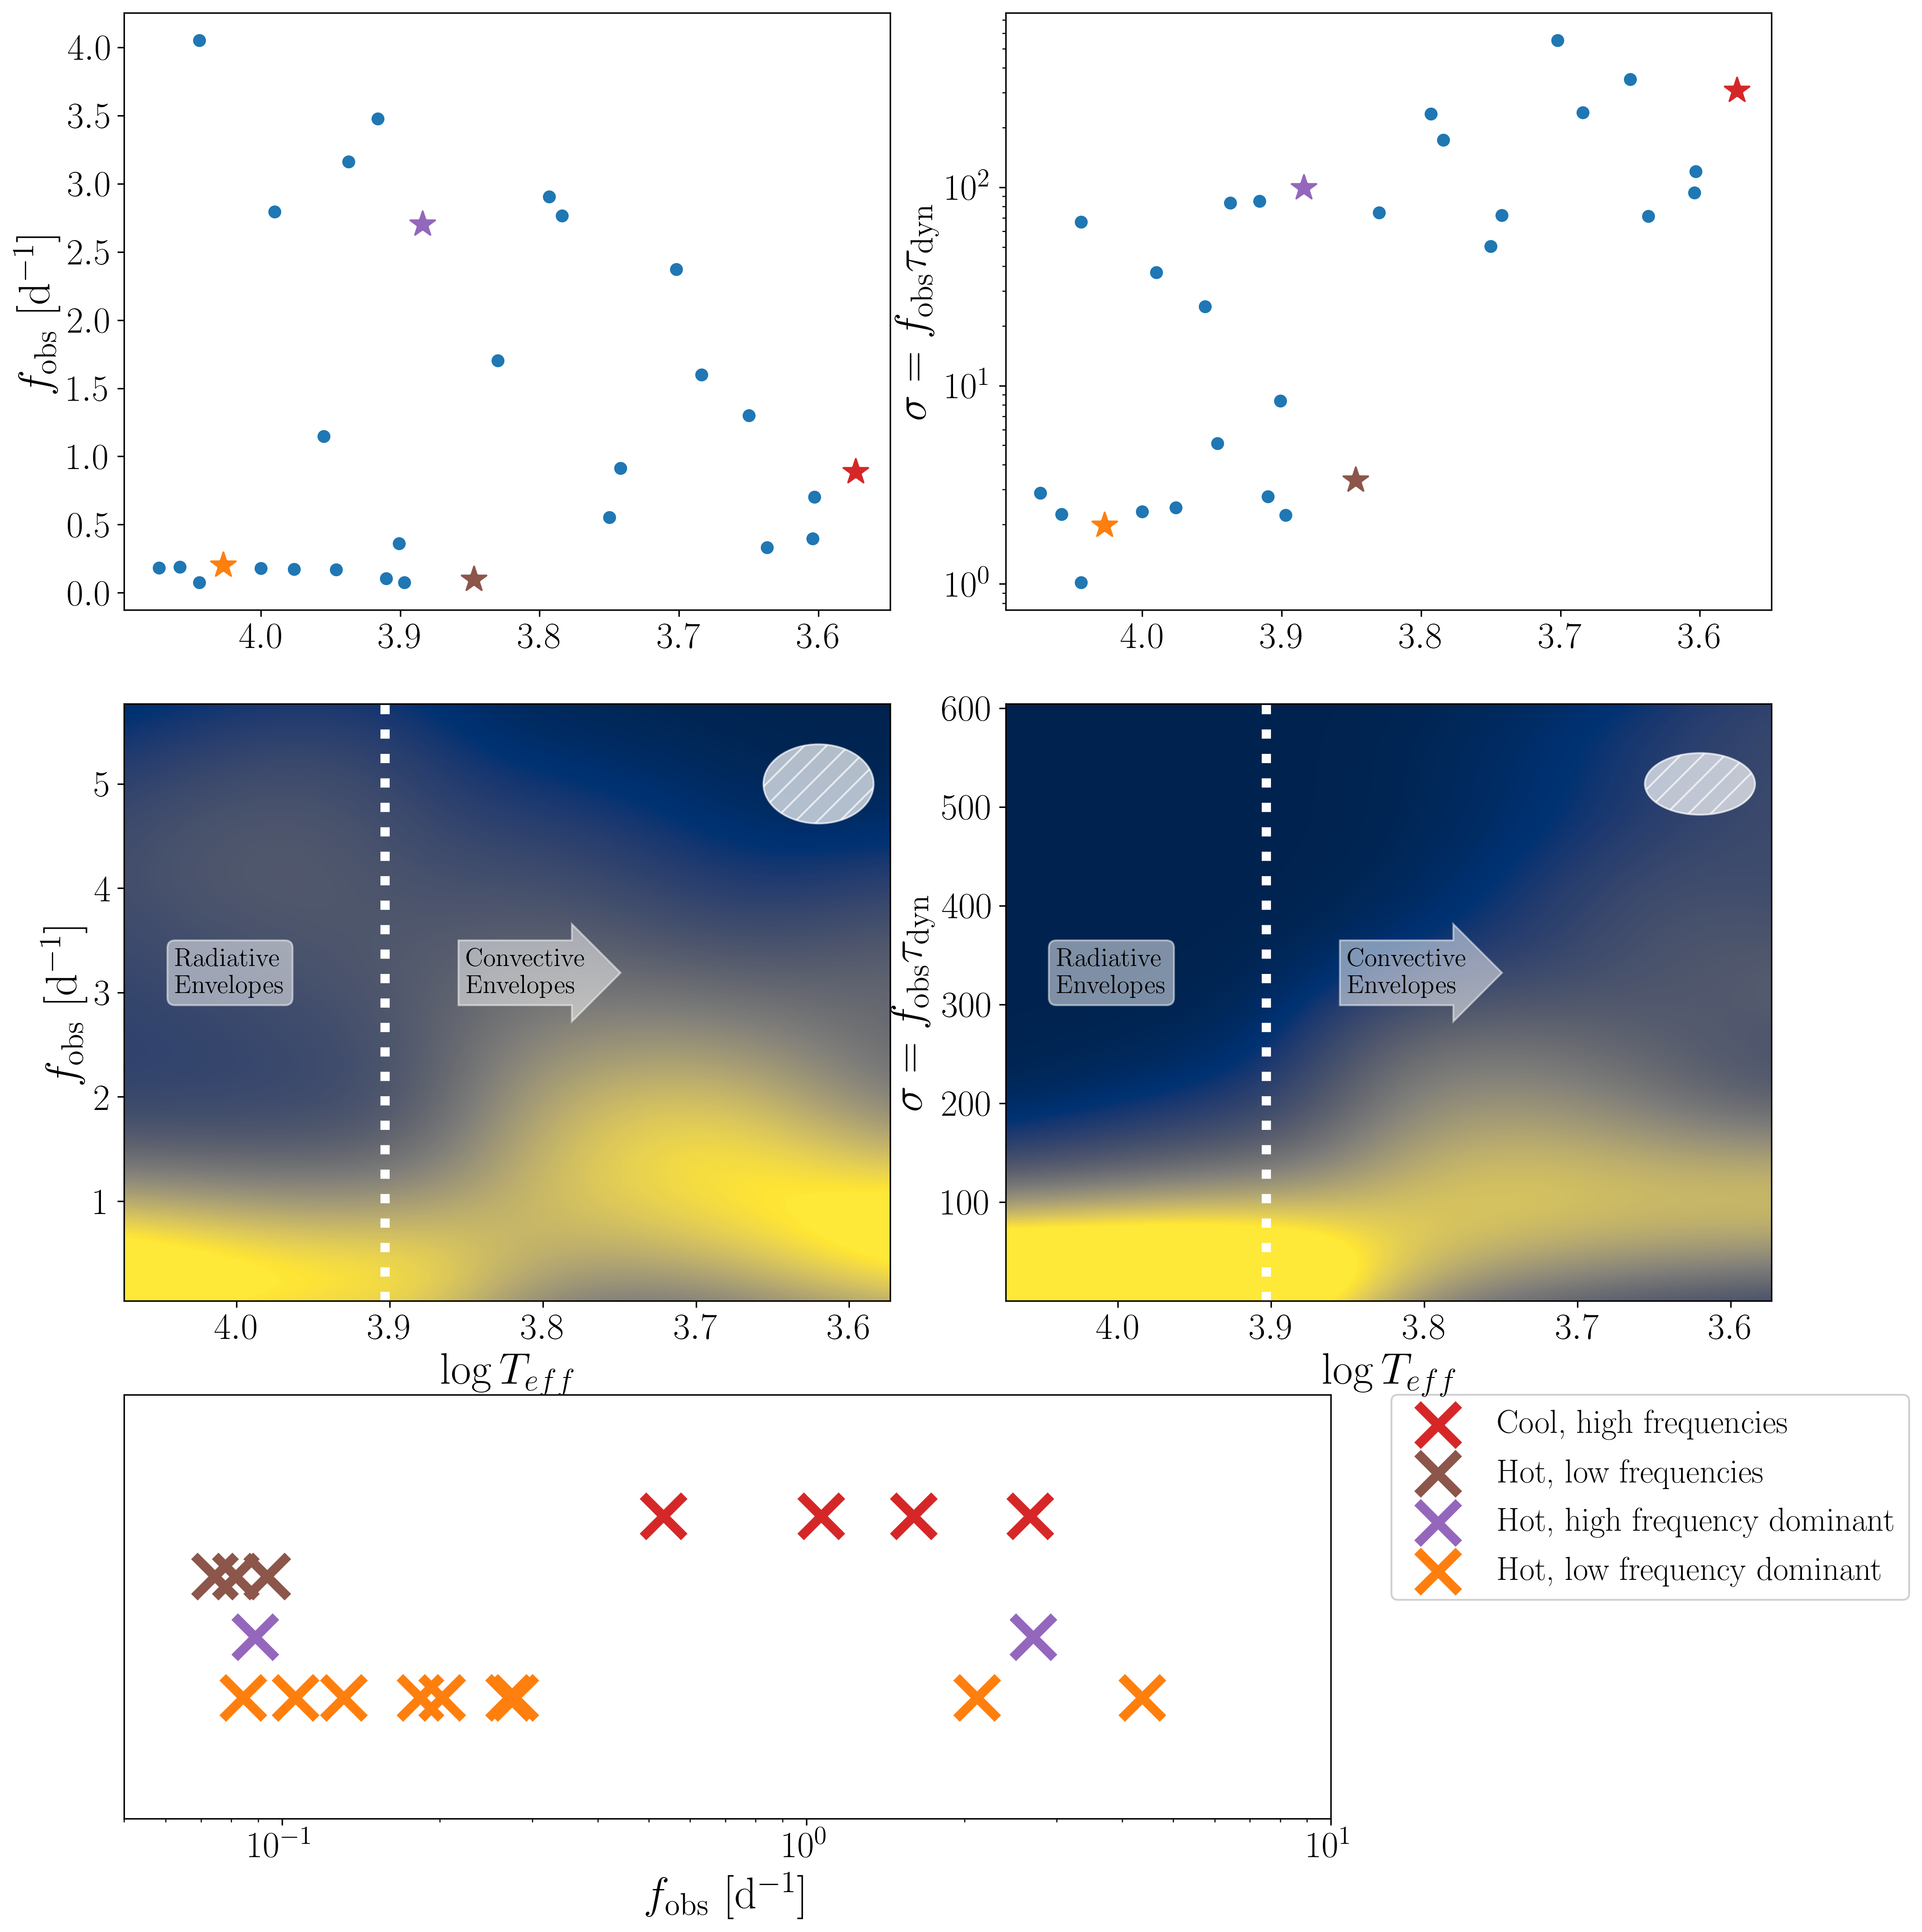

In [137]:
mosaic = """
AAAABBBB
AAAABBBB
AAAABBBB
AAAABBBB
CCCCDDDD
CCCCDDDD
CCCCDDDD
CCCCDDDD
EEEEEE..
EEEEEE..
EEEEEE..
"""
fig, axes = plt.subplot_mosaic(mosaic, figsize=(8*2, 6*3), dpi=300)

axes['A'].scatter(x_data_scatter, y_data_scatter, rasterized=True)
axes['A'].set_ylabel(r'$f_{\rm obs}$ [d$^{-1}$]')
axes['B'].scatter(x_data_scatter, z_data_scatter, rasterized=True)
axes['B'].set_yscale('log')
axes['B'].set_ylabel(r'$\sigma = f_{\rm obs} \tau_{\rm dyn}$',fontsize=20)

axes['C'].pcolormesh(Xteff, Yf, KDE_teff_f, shading='nearest', cmap='cividis',vmin=0.0,vmax=0.5, rasterized=True)
axes['C'].set_xlabel(r'$\log T_{eff}$')
axes['C'].set_ylabel(r'$f_{\rm obs}$ [d$^{-1}$]')

axes['C'].add_patch(Ellipse((3.62, 5.0), xtf_width, ytf_width, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))
axes['C'].axvline(x=np.log10(8000),c='w',lw=5,ls=':')

axes['C'].text(3.85, 3.0, 'Convective\nEnvelopes', fontsize=14,
       bbox=dict(boxstyle="rarrow",
                   ec='w',
                   fc='w',
                   alpha=0.5
                   ))
axes['C'].text(4.04, 3.0, 'Radiative\nEnvelopes', fontsize=14,
       bbox=dict(boxstyle="round",
                   ec='w',
                   fc='w',
                   alpha=0.5
                   ))

yl = axes['C'].get_ylim()

axes['D'].pcolormesh(Xteff_sig, Ysigma, KDE_teff_sigma, shading='nearest', cmap='cividis',vmin=0.0,vmax=0.5, rasterized=True)
axes['D'].set_xlabel(r'$\log T_{eff}$')
axes['D'].set_ylabel(r'$\sigma = f_{\rm obs} \tau_{\rm dyn}$')

yl_this = axes['D'].get_ylim()

ellipse_y = (((5.0 - yl[0]) / (yl[1] - yl[0])) * (yl_this[1] - yl_this[0])) + yl_this[0]

axes['D'].add_patch(Ellipse((3.62, ellipse_y), xts_width, yts_width, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))
axes['D'].axvline(x=np.log10(8000),c='w',lw=5,ls=':')

text_y = (((3.0 - yl[0]) / (yl[1] - yl[0])) * (yl_this[1] - yl_this[0])) + yl_this[0]
axes['D'].text(3.85, text_y, 'Convective\nEnvelopes', fontsize=14,
       bbox=dict(boxstyle="rarrow",
                   ec='w',
                   fc='w',
                   alpha=0.5
                   ))
axes['D'].text(4.04, text_y, 'Radiative\nEnvelopes', fontsize=14,
       bbox=dict(boxstyle="round",
                   ec='w',
                   fc='w',
                   alpha=0.5
                   ))

def grab_ex(teff_max = np.inf, teff_min = -np.inf, gal='LMC', fdom_max = np.inf, fdom_min = 0.0,
            nf_min = 0.0, nf_max = np.inf, highf_min = 0.0, highf_max = np.inf, lowf_min = 0.0,
            lowf_max = np.inf):
    """
    Grab an example star with the highest amplitude frequencies satisfying criteria! 
    """
    idx = ((np.array(x_data_scatter) <= teff_max) & 
           (np.array(x_data_scatter) >= teff_min) &
           (np.array(gal_data_scatter) == gal) &
           (np.array(y_data_scatter) >= fdom_min) &
           (np.array(y_data_scatter) <= fdom_max) &
           (np.array(nf_data_scatter) <= nf_max) & 
           (np.array(nf_data_scatter) >= nf_min) & 
           (np.array(highf_data_scatter) <= highf_max) & 
           (np.array(highf_data_scatter) >= highf_min) & 
           (np.array(lowf_data_scatter) <= lowf_max) & 
           (np.array(lowf_data_scatter) >= lowf_min) 
           )
    
    tic = np.array(tic_data_scatter)[idx]
    amp = np.array(amp_data_scatter)[idx]
    f = np.array(y_data_scatter)[idx]
    sig = np.array(z_data_scatter)[idx]
    temp = np.array(x_data_scatter)[idx]
    
    ex_idx = np.argmax(amp)
    
    tic_ex = tic[ex_idx]
    f_ex = f[np.argmax(ex_idx)]
    sig_ex = sig[np.argmax(ex_idx)]
    t_ex = temp[np.argmax(ex_idx)]
    ex = candidate_fyps.loc[tic_ex]
    
    return tic_ex, t_ex, f_ex, sig_ex, ex
    

#Now pick some good example periodograms
# One at low temp
tic_exlow, t_exlow, f_exlow, sig_exlow, exlow = grab_ex(teff_max=3.8)
axes['A'].scatter(t_exlow,f_exlow,marker='*',s=200,c='C3')
axes['B'].scatter(t_exlow,sig_exlow,marker='*',s=200,c='C3')

with h5.File('prewhitening.hdf5', 'r') as f:
    good_fs = f[f'{tic_exlow}/good_fs'][()][:,0]

this_y = 0.3
this_y = np.tile(this_y,len(good_fs))
axes['E'].scatter(good_fs,this_y,c='C3',s=500,linewidth=5,marker='x',label='Cool, high frequencies')

#Now a hot one with only low frequencies one
tic_exhotlo, t_exhotlo, f_exhotlo, sig_exhotlo, exhotlo = grab_ex(teff_min=3.8,nf_min=3,nf_max=5, highf_max=0.5)
axes['A'].scatter(t_exhotlo,f_exhotlo,marker='*',s=200,c='C5')
axes['B'].scatter(t_exhotlo,sig_exhotlo,marker='*',s=200,c='C5')

with h5.File('prewhitening.hdf5', 'r') as f:
    good_fs = f[f'{tic_exhotlo}/good_fs'][()][:,0]

this_y = 0.2
this_y = np.tile(this_y,len(good_fs))
axes['E'].scatter(good_fs,this_y,c='C5',s=500,linewidth=5,marker='x',label='Hot, low frequencies')

#Now a hot, high frequency one
tic_exhi, t_exhi, f_exhi, sig_exhi, exhi = grab_ex(teff_min=3.8, fdom_min=2.0)
axes['A'].scatter(t_exhi,f_exhi,marker='*',s=200,c='C4')
axes['B'].scatter(t_exhi,sig_exhi,marker='*',s=200,c='C4')

with h5.File('prewhitening.hdf5', 'r') as f:
    good_fs = f[f'{tic_exhi}/good_fs'][()][:,0]

this_y = 0.1
this_y = np.tile(this_y,len(good_fs))
axes['E'].scatter(good_fs,this_y,c='C4',s=500,linewidth=5,marker='x',label='Hot, high frequency dominant')


#Now a hot, low frequency one
tic_exhot, t_exhot, f_exhot, sig_exhot, exhot = grab_ex(teff_min=4.02, fdom_max=0.5)
axes['A'].scatter(t_exhot,f_exhot,marker='*',s=200,c='C1')
axes['B'].scatter(t_exhot,sig_exhot,marker='*',s=200,c='C1')

with h5.File('prewhitening.hdf5', 'r') as f:
    good_fs = f[f'{tic_exhot}/good_fs'][()][:,0]

this_y = 0
this_y = np.tile(this_y,len(good_fs))
axes['E'].scatter(good_fs,this_y,c='C1',s=500,linewidth=5,marker='x',label='Hot, low frequency dominant')



axes['E'].set_xlim(0.05,10)
axes['E'].set_ylim(-0.2,0.5)
axes['E'].legend(loc='upper left', fontsize=18, framealpha=0.9, 
                 bbox_to_anchor=(1.05, 1), borderaxespad=0.)
axes['E'].set_xlabel(r'$f_{\rm obs}$ [d$^{-1}$]')
axes['E'].set_yticks([])
axes['E'].set_xscale('log')

for k in axes.keys():
    ax = axes[k]
    if k != 'E':
        ax.invert_xaxis()
    ax.xaxis.label.set_size(24)
    ax.yaxis.label.set_size(24)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
#plt.tight_layout()
fig.subplots_adjust(wspace=1.1,hspace=1.2)
plt.savefig('../plots/freq_scaling.pdf', bbox_inches='tight')

In [92]:
tic_exhotlo, t_exhotlo, f_exhotlo, sig_exhotlo, exhotlo

(277022505,
 3.637,
 0.33111370344798047,
 71.63396935207658,
 RA                                      83.76501
 Dec                                   -69.750564
 dist                                    0.034086
 pmRA                                     1.87152
 pmDec                                   0.508153
 Tmag                                      9.6554
 ContRatio                                    NaN
 SpT                                          YSG
 CommonName                             HD 269786
 MKType                                         B
 SimbadOType                                 Star
 SimbadSpT                                    B1I
 teff                                         4.0
 lum                                        5.116
 SpecSource                                     N
 Gal                                          LMC
 w1mag                                     10.901
 w2mag                                     10.894
 w3mag                                

# Throwing in things with lots of frequencies...

In [93]:
filter_high_frequencies = True
filter_many_frequencies = False
scale_tdyn = True
KDE_res = 1000 #resolution of KDE

scaler = StandardScaler()
x_data = []
y_data = []
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn
        y_data.append(y)
    
data = np.array([x_data,y_data]).T
data_scaled = scaler.fit_transform(data)
data_scaled_teff = data_scaled[:,0][:,np.newaxis]
data_scaled_teff


# First we're going to do a KDE along the Teff axis to account for distribution in HR diagram
params = {'bandwidth': np.arange(0.1,0.4,0.0001)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data_scaled_teff)
  
teff_bandwidth = grid.best_estimator_.bandwidth
print(teff_bandwidth)

kde_teff = KernelDensity(bandwidth=teff_bandwidth)
kde_teff.fit(data_scaled_teff)

xteff = np.linspace(data_scaled_teff.min(),data_scaled_teff.max(),KDE_res)

#compute the KDE
Z_teff = np.exp(kde_teff.score_samples(xteff.reshape(-1, 1)))

#Now we do the same in T vs. freq space
params = {'bandwidth': np.arange(0.01,0.4,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data_scaled)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data_scaled)

X, Y = np.meshgrid(np.linspace(np.min(data_scaled[:,0]),np.max(data_scaled[:,0]),KDE_res), 
                   np.linspace(np.min(data_scaled[:,1]),np.max(data_scaled[:,1]),KDE_res))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (KDE_res,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

mesh_inv = scaler.inverse_transform(xy).reshape(KDE_res,KDE_res,2)
X_inv = mesh_inv[:,:,0]
Y_inv = mesh_inv[:,:,1]

0.40000000000000857
0.3989999999999997


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega$')]

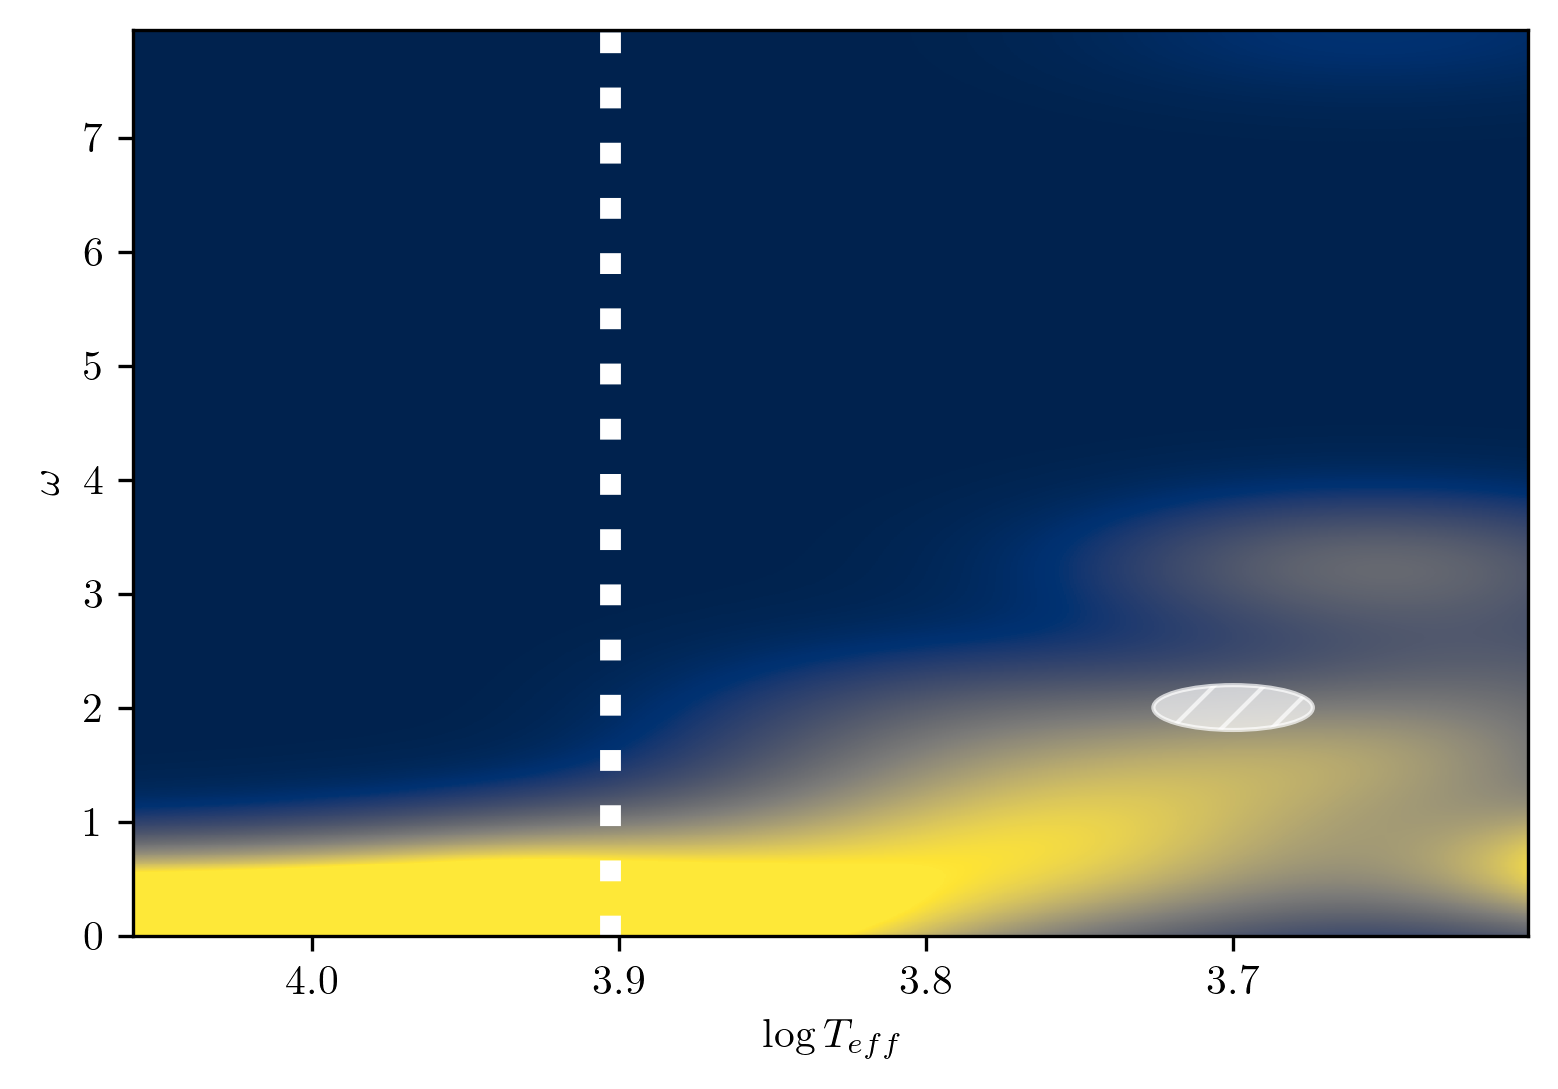

In [94]:
#Make the plot in inverse_scaled space
fig = plt.figure(dpi=300)
plt.pcolormesh(X_inv, Y_inv/1e-8, Z_fteff_scale, shading='nearest', cmap='cividis',vmin=0.0,vmax=0.5)

widths = [[0.0,0.0],[0.0,fteff_bandwidth],[fteff_bandwidth,0.0]]
width_inv = scaler.inverse_transform(widths)
y_width = np.abs(width_inv[0,1]-width_inv[1,1])
x_width = np.abs(width_inv[0,0]-width_inv[2,0])

ax = plt.gca()
ax.add_patch(Ellipse((3.7, 2.0), x_width, y_width/1e-8, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.invert_xaxis()
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega$')

# And objects with weirdly high frequencies

In [95]:
filter_high_frequencies = False
filter_many_frequencies = False
scale_tdyn = True
KDE_res = 1000 #resolution of KDE

scaler = StandardScaler()
x_data = []
y_data = []
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn
        y_data.append(y)
    
data = np.array([x_data,y_data]).T
data_scaled = scaler.fit_transform(data)
data_scaled_teff = data_scaled[:,0][:,np.newaxis]
data_scaled_teff


# First we're going to do a KDE along the Teff axis to account for distribution in HR diagram
params = {'bandwidth': np.arange(0.1,0.4,0.0001)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data_scaled_teff)
  
teff_bandwidth = grid.best_estimator_.bandwidth
print(teff_bandwidth)

kde_teff = KernelDensity(bandwidth=teff_bandwidth)
kde_teff.fit(data_scaled_teff)

xteff = np.linspace(data_scaled_teff.min(),data_scaled_teff.max(),KDE_res)

#compute the KDE
Z_teff = np.exp(kde_teff.score_samples(xteff.reshape(-1, 1)))

#Now we do the same in T vs. freq space
params = {'bandwidth': np.arange(0.01,0.4,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data_scaled)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data_scaled)

X, Y = np.meshgrid(np.linspace(np.min(data_scaled[:,0]),np.max(data_scaled[:,0]),KDE_res), 
                   np.linspace(np.min(data_scaled[:,1]),np.max(data_scaled[:,1]),KDE_res))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (KDE_res,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

mesh_inv = scaler.inverse_transform(xy).reshape(KDE_res,KDE_res,2)
X_inv = mesh_inv[:,:,0]
Y_inv = mesh_inv[:,:,1]

0.40000000000000857
0.3989999999999997


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega$')]

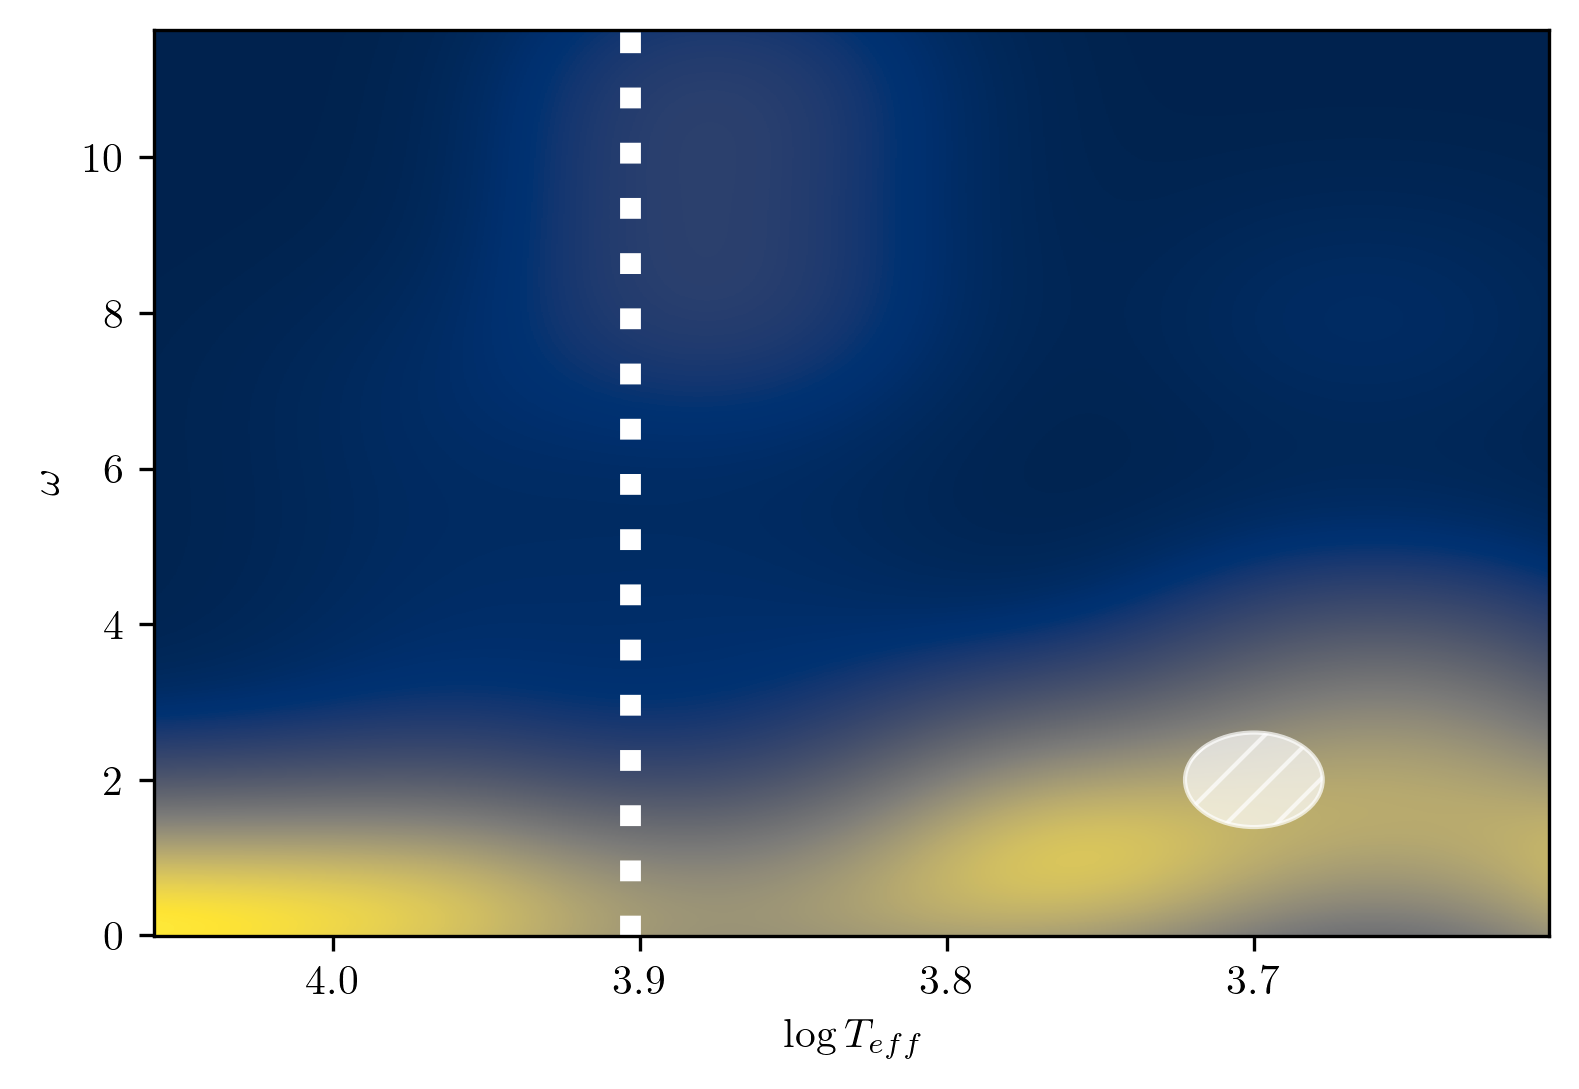

In [97]:
#Make the plot in inverse_scaled space
fig = plt.figure(dpi=300)
plt.pcolormesh(X_inv, Y_inv/1e-8, Z_fteff_scale, shading='nearest', cmap='cividis')

widths = [[0.0,0.0],[0.0,fteff_bandwidth],[fteff_bandwidth,0.0]]
width_inv = scaler.inverse_transform(widths)
y_width = np.abs(width_inv[0,1]-width_inv[1,1])
x_width = np.abs(width_inv[0,0]-width_inv[2,0])

ax = plt.gca()
ax.add_patch(Ellipse((3.7, 2.0), x_width, y_width/1e-8, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.invert_xaxis()
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega$')

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$f_{\\rm obs}$')]

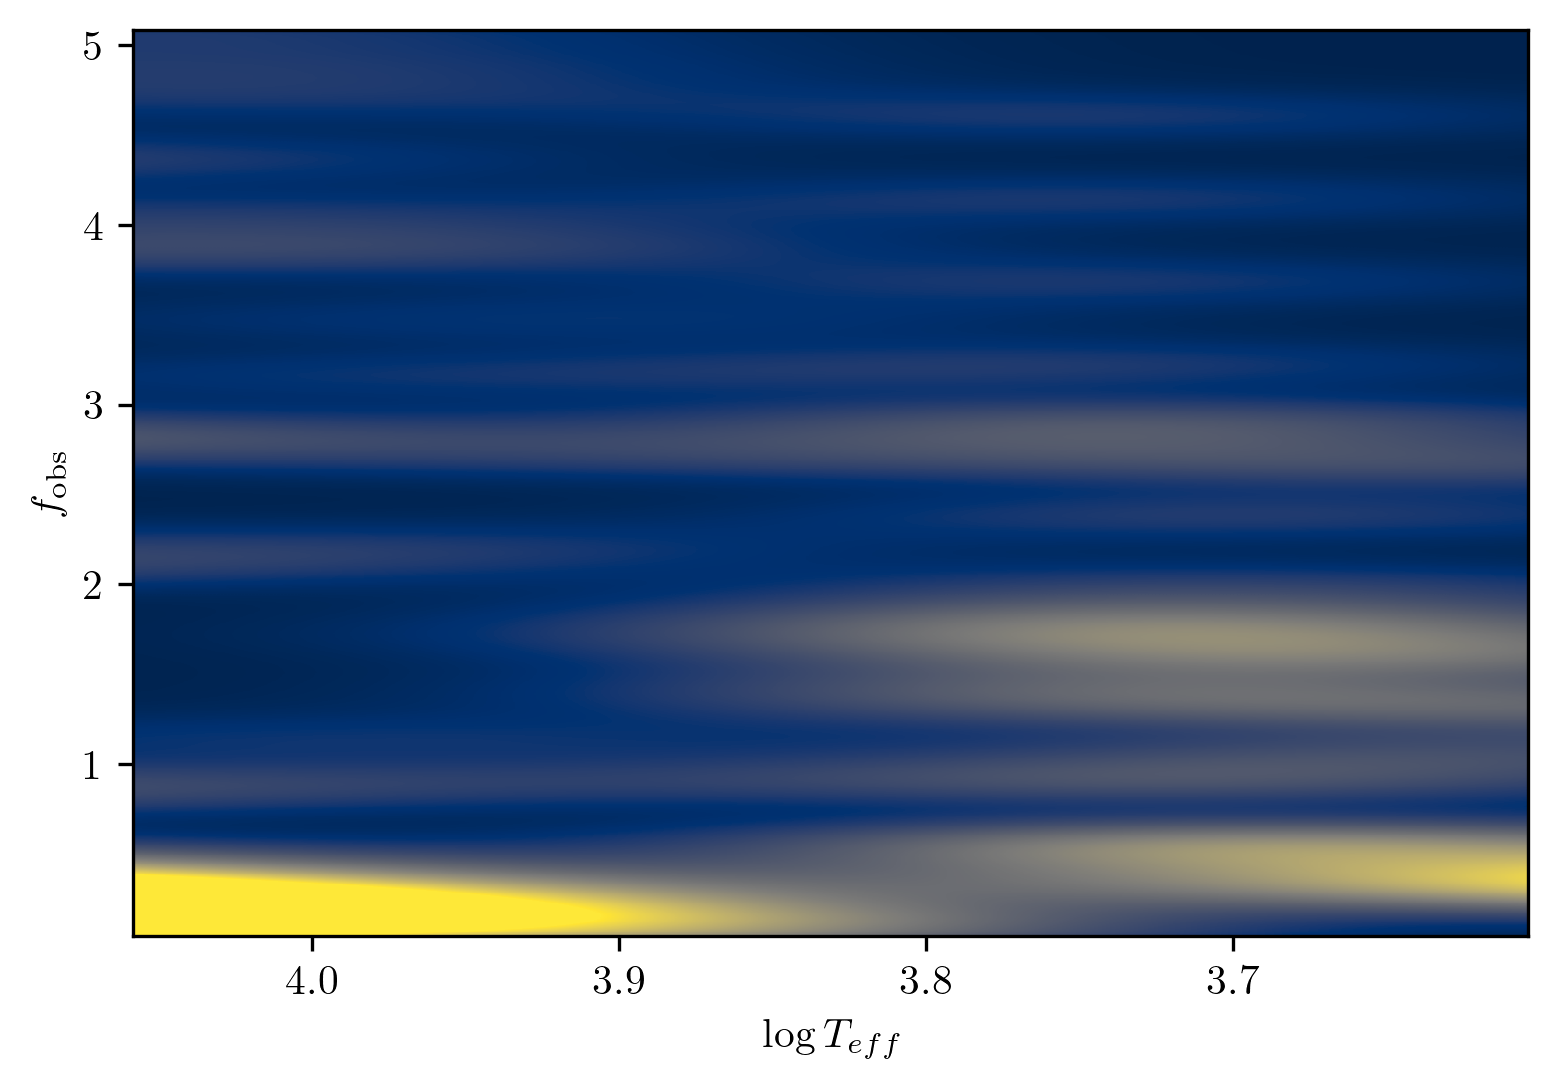

In [22]:
x_data = []
y_data = []
filter_high_frequencies = True
filter_many_frequencies = True
scale_tdyn = False
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=1)

ax = plt.gca()
ax.invert_xaxis()
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$f_{\rm obs}$')

# And again, scaling by tdyn

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega/10^{-8}$')]

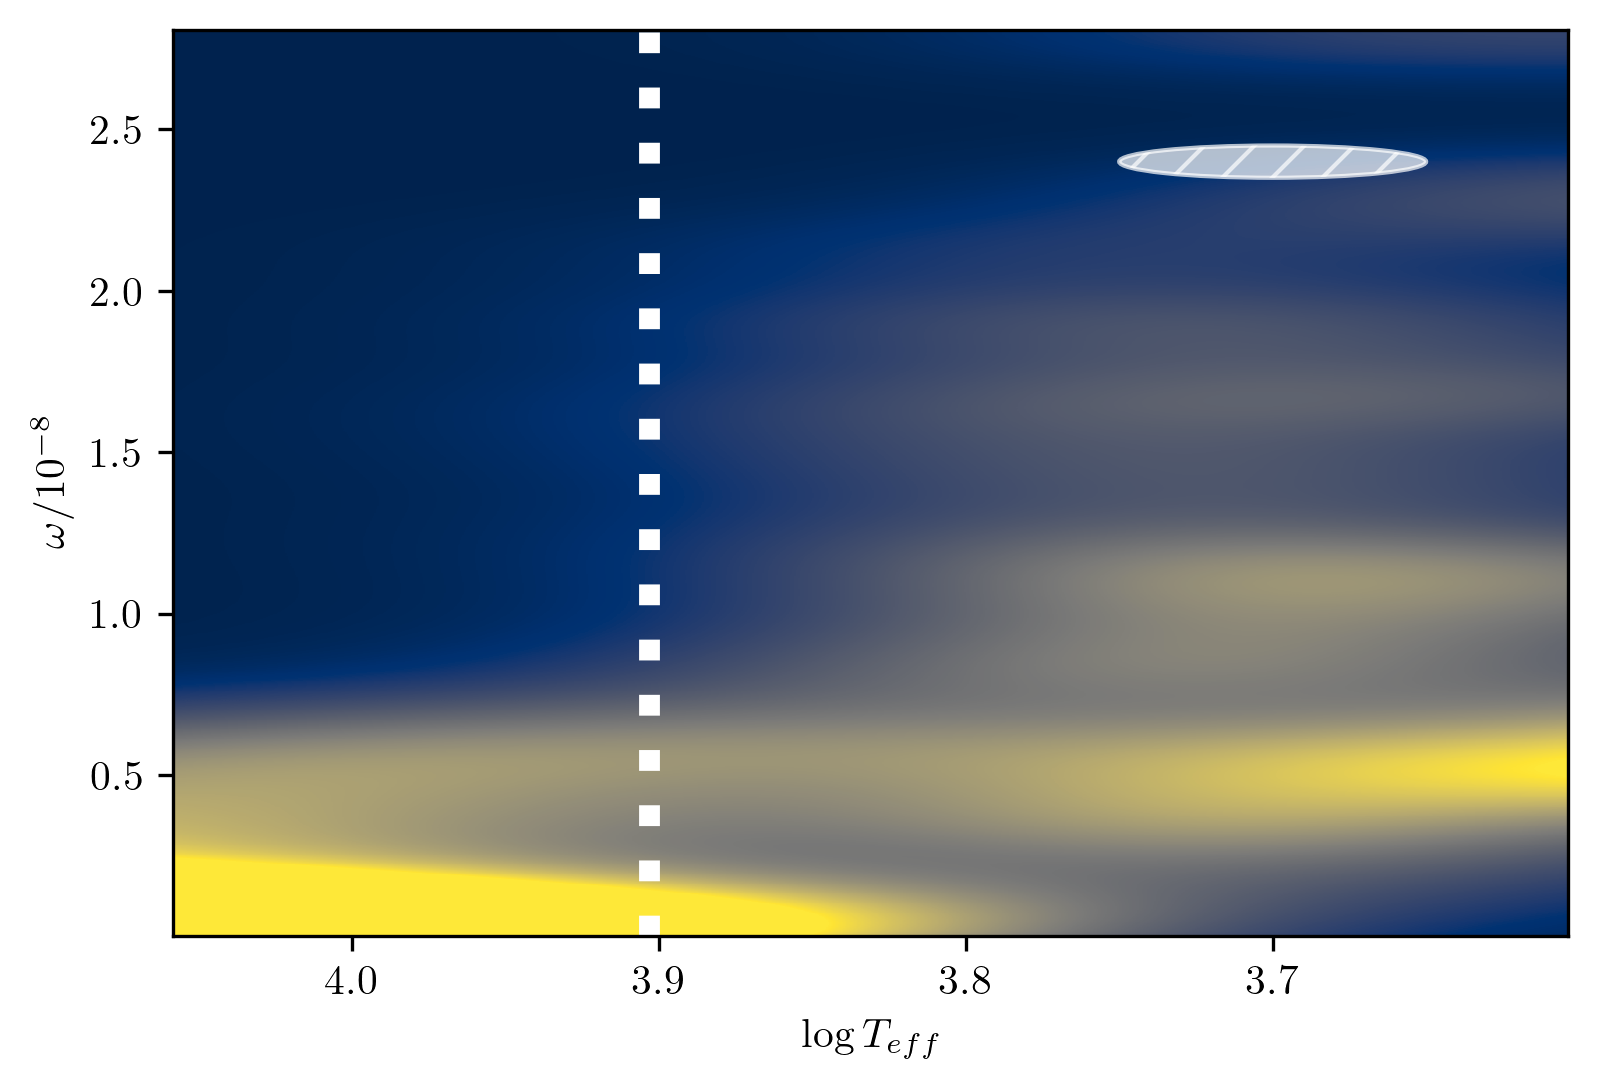

In [33]:
from astropy.constants import G
import astropy.units as u
from matplotlib.patches import Ellipse
Tsun = 5778
x_data = []
y_data = []
filter_high_frequencies = True
filter_many_frequencies = True
scale_tdyn = True
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn/1e-8
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=1)

ax = plt.gca()
ax.add_patch(Ellipse((4.0, 2.4), 0.1, 0.1, angle=0, alpha=0.7,edgecolor='w',facecolor='w',lw=1,hatch='//'))

ax.invert_xaxis()
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega/10^{-8}$')

# Now let's actually keep the things that have lots of frequencies...

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega/10^{-8}$')]

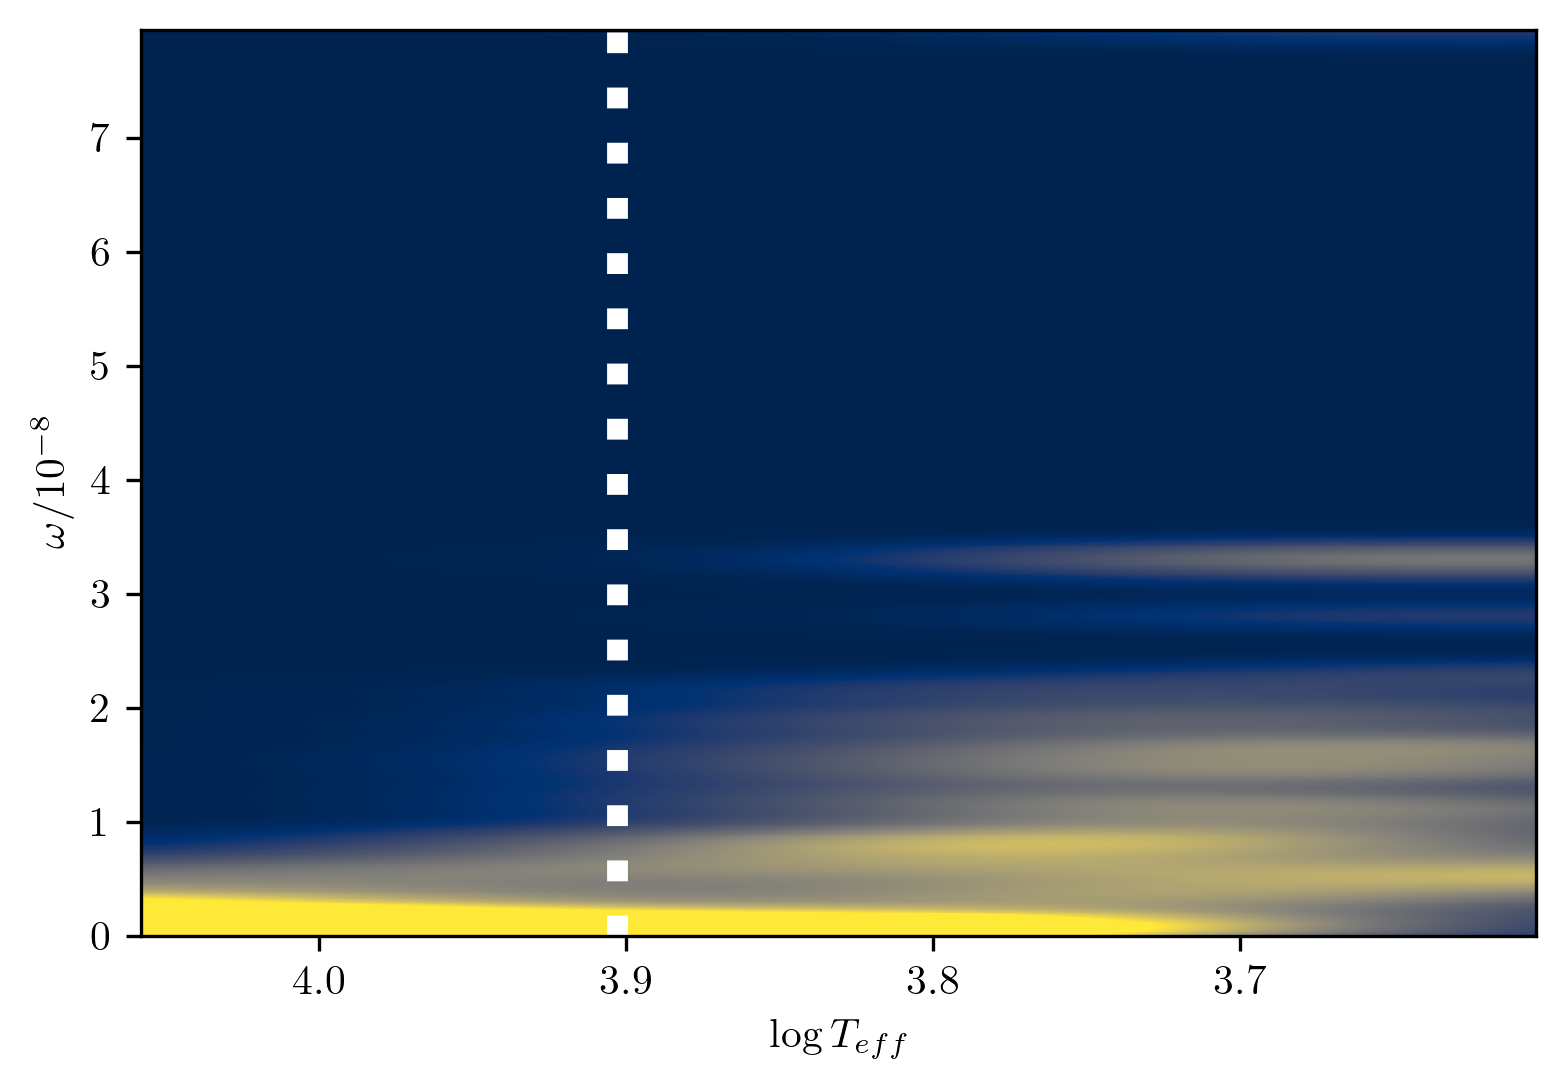

In [24]:
x_data = []
y_data = []
filter_high_frequencies = True
filter_many_frequencies = False
scale_tdyn = True
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn/1e-8
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=0.75)

ax = plt.gca()
ax.invert_xaxis()
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega/10^{-8}$')

# aaaaand add in things with high frequencies...

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'), Text(0, 0.5, '$\\omega/10^{-8}$')]

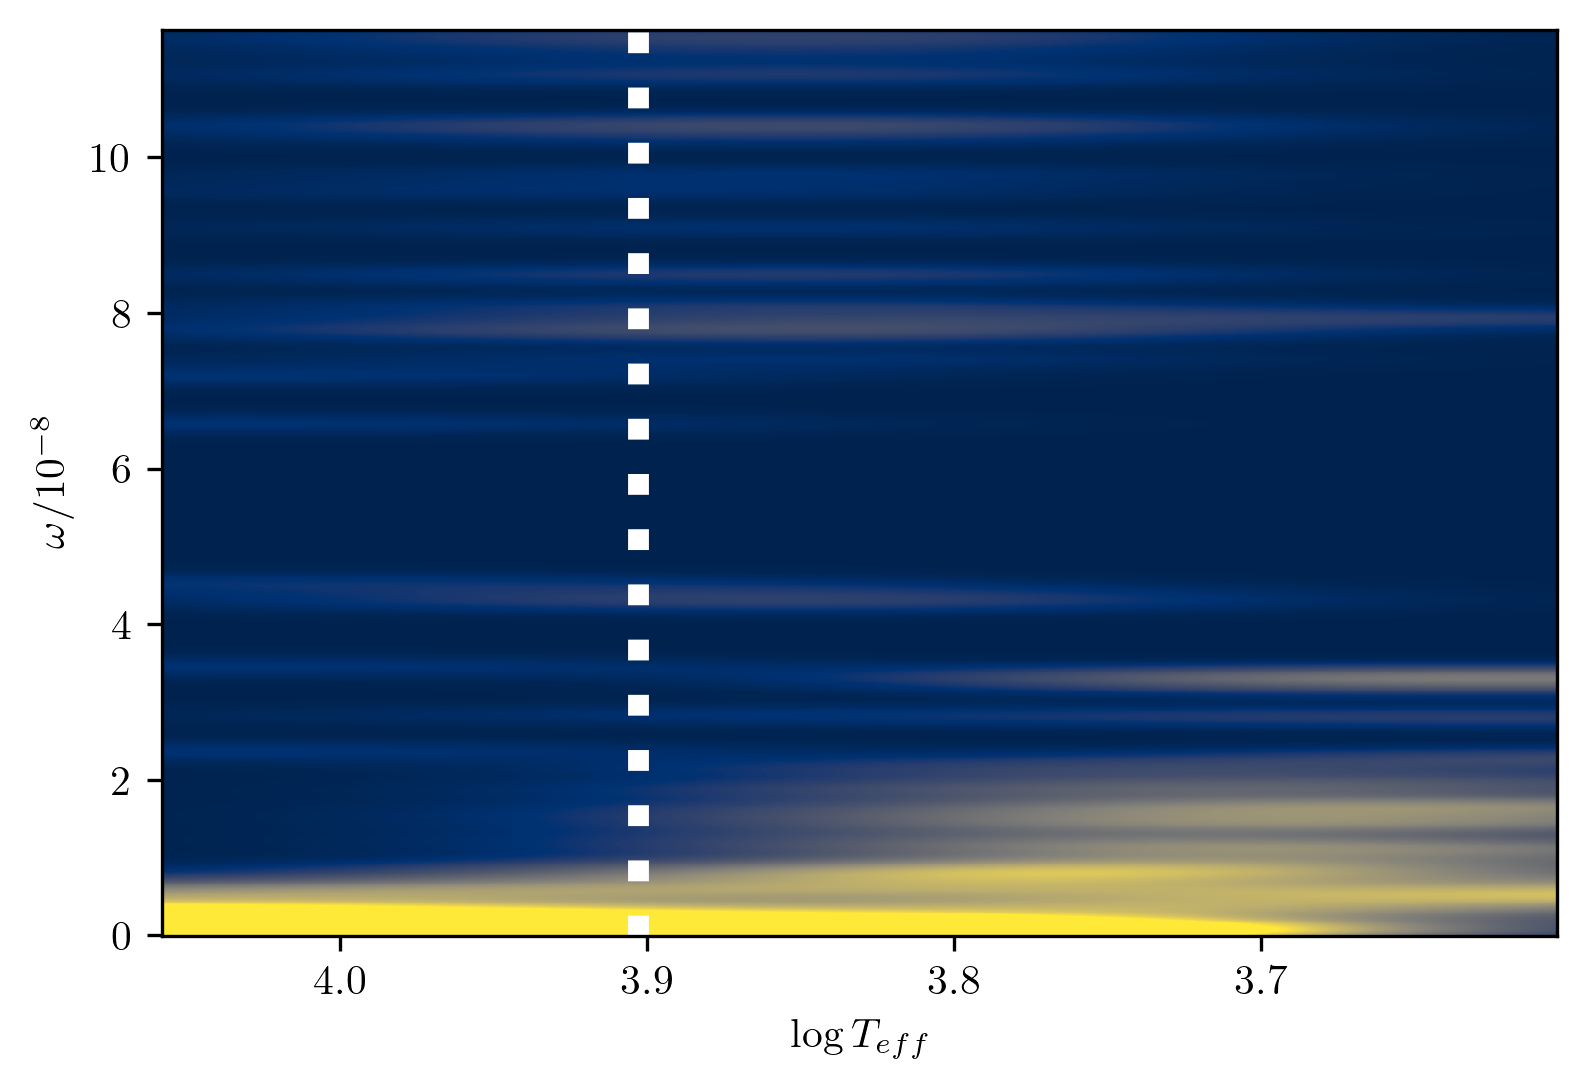

In [25]:
x_data = []
y_data = []
filter_high_frequencies = False
filter_many_frequencies = False
scale_tdyn = True
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn/1e-8
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=0.5)

ax = plt.gca()
ax.invert_xaxis()
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega/10^{-8}$')

# Zooming in on the low frequency domain

0.09999999999999992


[Text(0.5, 0, '$\\log T_{eff}$'),
 Text(0, 0.5, '$\\omega/10^{-8}$'),
 (0.0, 2.0)]

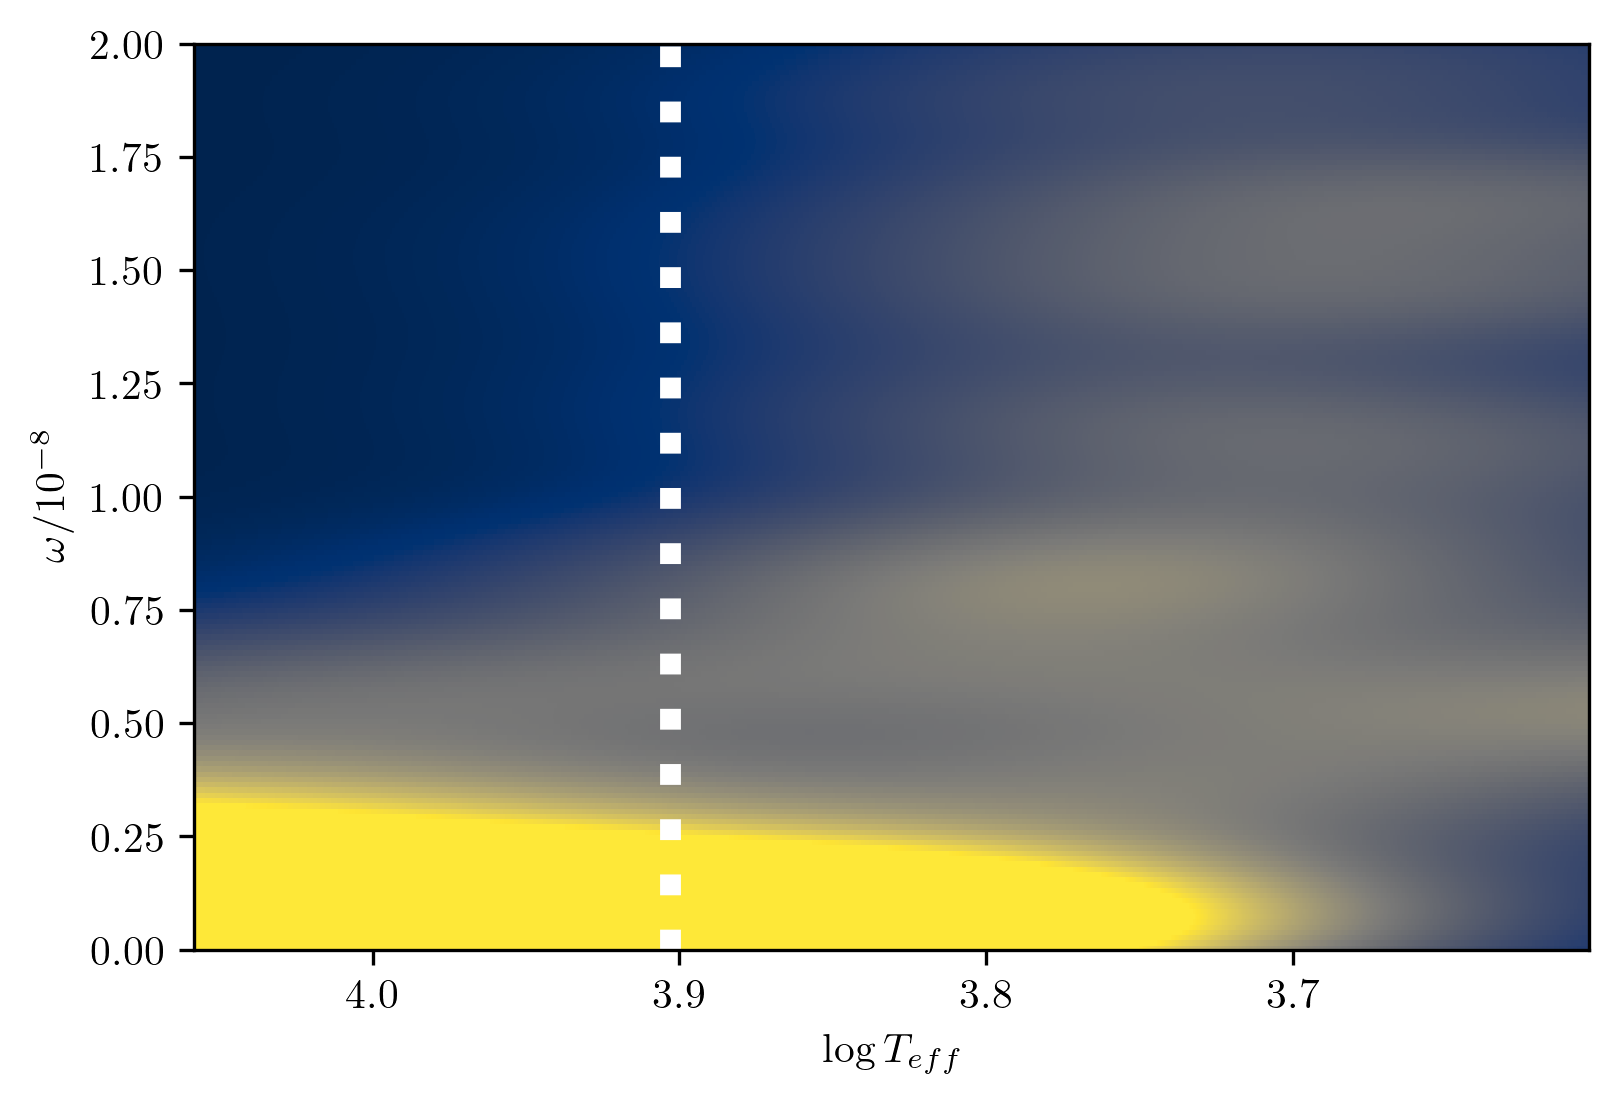

In [26]:
x_data = []
y_data = []
filter_high_frequencies = False
filter_many_frequencies = False
scale_tdyn = True
for tic,cf in candidate_fyps.iterrows():
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
    
    for f in good_fs[:,0]:
        x_data.append(cf['teff'])
        y = f
        if scale_tdyn:
            logr = 0.5*(cf['lum'] - 4.0*cf['teff'])
            r = np.power(10.0,logr)
            logM = cf['lum']/3.0
            M = np.power(10.0,logM)
            tdyn = np.sqrt(r**3.0 / M)
            y *= tdyn/1e-8
        y_data.append(y)
    
data = np.array([x_data,y_data]).T

params = {'bandwidth': np.arange(0.01,0.1,0.001)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(data)
    
fteff_bandwidth = grid.best_estimator_.bandwidth
print(fteff_bandwidth)

kde_fteff = KernelDensity(bandwidth=fteff_bandwidth)
kde_fteff.fit(data)

X, Y = np.meshgrid(np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000), 
                   np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000))

xy = np.vstack([X.ravel(), Y.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_fteff = np.exp(kde_fteff.score_samples(xy)).reshape(X.shape)

Z_teff_proj = np.tile(Z_teff, (1000,1))

Z_fteff_scale = Z_fteff/Z_teff_proj

fig = plt.figure(dpi=300)
plt.pcolormesh(X, Y, Z_fteff_scale, shading='nearest', cmap='cividis', vmin=0, vmax=0.75)

ax = plt.gca()
ax.invert_xaxis()
ax.axvline(x=np.log10(8000),c='w',lw=5,ls=':')
ax.set(xlabel=r'$\log T_{eff}$',ylabel=r'$\omega/10^{-8}$', ylim=(0,2))